In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, kstest
from scipy.stats import f_oneway, kruskal, bartlett, levene
import warnings
import seaborn as sns

# Isključivanje FutureWarning-a
warnings.filterwarnings("ignore", category=FutureWarning)

#### Utility functions

In [3]:
# Check if the data is normally distributed
def is_normal(data):
    if len(data) < 50:
        _, p = shapiro(data)
    else:
        _, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    return p > 0.05

# Perform either t-test or mann whitney
def perform_test(group1, group2, test_type):
    if test_type == 't-test':
        stat, p = ttest_ind(group1, group2, equal_var=False)
    else:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    return stat, p

# Is the variance equal?
def variance_test(data, normal):
    if normal:
        stat, p = bartlett(*data)
    else:
        stat, p = levene(*data)
    return p > 0.05

# Perform ANOVA or Kruskal
def perform_anova_kruskal(groups, test_type):
    if test_type == 'ANOVA':
        stat, p = f_oneway(*groups)
    else:
        stat, p = kruskal(*groups)
    return stat, p

In [4]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

In [5]:
print("circuits: ", ', '.join(circuits.columns.to_list()))
print("constructor_results: ", ', '.join(constructor_results.columns.to_list()))
print("constructor_standings: ", ', '.join(constructor_standings.columns.to_list()))
print("constructors: ", ', '.join(constructors.columns.to_list()))
print("driver_standings: ", ', '.join(driver_standings.columns.to_list()))
print("drivers: ", ', '.join(drivers.columns.to_list()))
print("lap_times: ", ', '.join(lap_times.columns.to_list()))
print("pit_stops: ", ', '.join(pit_stops.columns.to_list()))
print("qualifying: ", ', '.join(qualifying.columns.to_list()))
print("races: ", ', '.join(races.columns.to_list()))
print("results: ", ', '.join(results.columns.to_list()))
print("seasons: ", ', '.join(seasons.columns.to_list()))
print("sprint_results: ", ', '.join(sprint_results.columns.to_list()))
print("status: ", ', '.join(status.columns.to_list()))

circuits:  circuitId, circuitRef, name, location, country, lat, lng, alt, url
constructor_results:  constructorResultsId, raceId, constructorId, points, status
constructor_standings:  constructorStandingsId, raceId, constructorId, points, position, positionText, wins
constructors:  constructorId, constructorRef, name, nationality, url
driver_standings:  driverStandingsId, raceId, driverId, points, position, positionText, wins
drivers:  driverId, driverRef, number, code, forename, surname, dob, nationality, url
lap_times:  raceId, driverId, lap, position, time, milliseconds
pit_stops:  raceId, driverId, stop, lap, time, duration, milliseconds
qualifying:  qualifyId, raceId, driverId, constructorId, number, position, q1, q2, q3
races:  raceId, year, round, circuitId, name, date, time, url, fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time
results:  resultId, raceId, driverId, constructorId, number, grid, position, positionText, p

In [6]:
# Define a dictionary for each dataset and its important variables with descriptions

dataset_info = {
    "Results": {
        "raceId": "Identifies the specific race event. This is critical for associating the results with a particular race.",
        "driverId": "Identifies the driver. This is essential for matching each driver to their race results.",
        "grid": "The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.",
        "position": "The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.",
        "statusId": "Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.",
        "points": "The number of points awarded based on the driver's performance."
    },
    "Status": {
        "statusId": "Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the race or had an incident."
    }
}

# Function to print dataset variable explanations
def print_dataset_info(dataset_info):
    for dataset, variables in dataset_info.items():
        print(f"Dataset: {dataset}")
        for var, description in variables.items():
            print(f"  - {var}: {description}")
        print("\n")

# Call the function to print the dataset information
print_dataset_info(dataset_info)


Dataset: Results
  - raceId: Identifies the specific race event. This is critical for associating the results with a particular race.
  - driverId: Identifies the driver. This is essential for matching each driver to their race results.
  - grid: The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.
  - position: The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.
  - statusId: Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.
  - points: The number of points awarded based on the driver's performance.


Dataset: Status
  - statusId: Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the rac

### lets take a look into the dataset
-  trebamo naci varijable koje su bitne za nasu hipotezu

### za ovu hipotezu potrebni su mi datasetovi races.csv, results.csv, status.csv, circuits.csv, drivers.csv, lap_times.csv(opcionalno)

In [9]:
# Spajanje races i results
merged = pd.merge(races, results, on='raceId', how='inner')

# Spajanje s drivers
merged = pd.merge(merged, drivers, on='driverId', how='inner')

# Spajanje sa status
merged = pd.merge(merged, status, on='statusId', how='inner')

# Pregled podataka
print(merged.head())

   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       1  2009      1          1  Australian Grand Prix  2009-03-29   
2       1  2009      1          1  Australian Grand Prix  2009-03-29   
3       1  2009      1          1  Australian Grand Prix  2009-03-29   
4       1  2009      1          1  Australian Grand Prix  2009-03-29   

     time_x                                              url_x fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
2  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
3  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
4  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   

  fp1_time  ... statusId    driverRef number_y code  forename      surname  \
0       \N  ...        1       button 

In [10]:
print(merged.columns)

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_y',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url_y', 'status'],
      dtype='object')


In [11]:
# Odabrati samo potrebne stupce
columns_to_keep = ['raceId', 'year', 'circuitId', 'name', 
                   'resultId', 'driverId', 'constructorId', 'grid', 
                   'positionText','positionOrder', 'points', 'laps', 'time_y', 
                   'milliseconds', 'fastestLap', 'fastestLapTime', 
                   'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status']

# Filtriranje 'merged' DataFrame-a na samo željene stupce
filtered_data = merged[columns_to_keep]

# Provjeri rezultate
print(filtered_data.head())

   raceId  year  circuitId                   name  resultId  driverId  \
0       1  2009          1  Australian Grand Prix      7554        18   
1       1  2009          1  Australian Grand Prix      7555        22   
2       1  2009          1  Australian Grand Prix      7556        15   
3       1  2009          1  Australian Grand Prix      7557        10   
4       1  2009          1  Australian Grand Prix      7558         4   

   constructorId  grid positionText  positionOrder  ...  laps       time_y  \
0             23     1            1              1  ...    58  1:34:15.784   
1             23     2            2              2  ...    58       +0.807   
2              7    20            3              3  ...    58       +1.604   
3              7    19            4              4  ...    58       +4.435   
4              4    10            5              5  ...    58       +4.879   

  milliseconds fastestLap fastestLapTime fastestLapSpeed statusId  forename  \
0      565578

### Top 10 drivers with most incidents

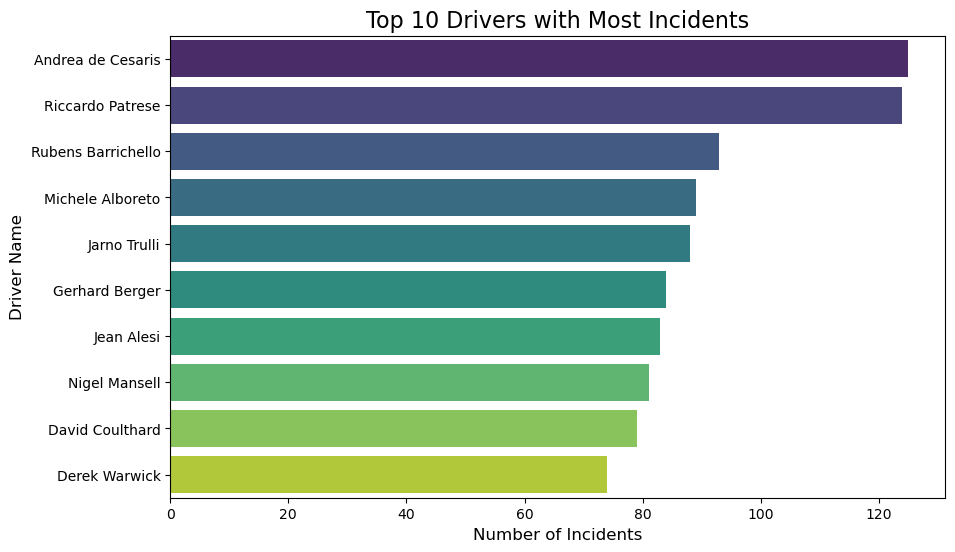

In [13]:
incident_statuses = ['Accident', 'Collision', 'Retired', 'Spun off', 'Mechanical', 
                     'Tyre', 'Puncture', 'Engine', 'Gearbox', 'Transmission', 
                     'Clutch', 'Hydraulics', 'Electrical', 'Radiator', 'Suspension', 
                     'Brakes', 'Differential', 'Overheating', 'Driveshaft', 
                     'Fuel pressure', 'Front wing', 'Water pressure', 'Wheel', 
                     'Throttle', 'Steering', 'Broken wing', 'Heat shield fire', 
                     'Exhaust', 'Oil leak', 'Engine fire', 'Engine misfire', 
                     'Tyre puncture', 'Out of fuel', 'Wheel nut', 'Injured', 
                     'Safety concerns', 'Fatal accident', 'Collision damage', 'Damage']

# Filtriranje podataka samo za incidente
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Brojanje incidenata po vozaču
incidents_per_driver = incidents['driverId'].value_counts()

# Kreiranje novog stupca s imenom i prezimenom vozača
incidents_with_names = incidents['forename'] + ' ' + incidents['surname']

# Brojanje incidenata po imenu vozača
incidents_per_driver_name = incidents_with_names.value_counts()

# Prikazivanje top 10 vozača s najviše incidenata
top_10_incidents = incidents_per_driver_name.head(10)

# Kreiranje horizontalnog bar grafa bez upozorenja
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_incidents.values, y=top_10_incidents.index, palette='viridis', hue=top_10_incidents.index, legend=False)

# Dodavanje naslova i oznaka osi
plt.title('Top 10 Drivers with Most Incidents', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Driver Name', fontsize=12)

# Prikazivanje grafa
plt.show()


### Incident per starting position(grid position)

grid
15    402
13    400
14    398
16    393
11    391
17    390
12    385
18    385
10    383
19    378
20    377
8     349
9     341
6     340
7     334
5     326
21    302
4     301
22    283
3     269
2     254
1     233
24    191
23    186
25    135
26    116
0      43
27     21
28     14
29     11
30     11
31      7
32      6
33      2
34      1
Name: count, dtype: int64


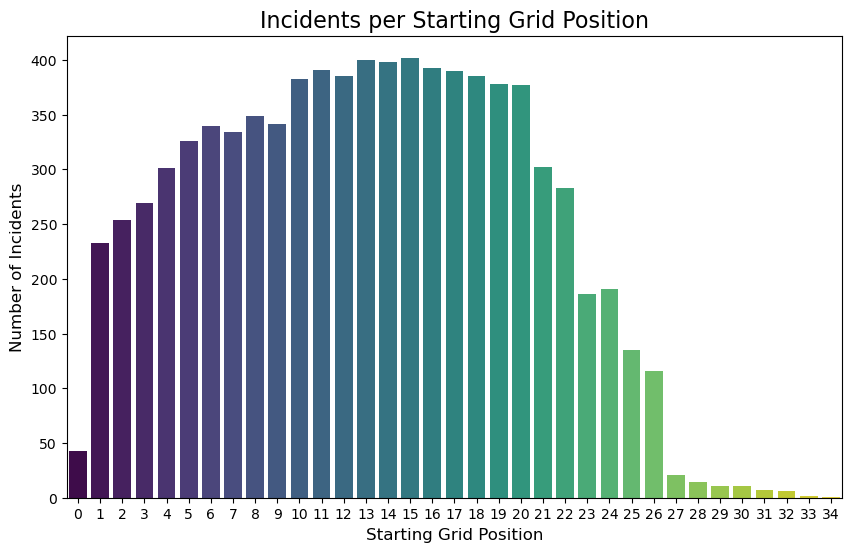

In [15]:
# Filtriranje podataka za incidente
incident_statuses = ['Accident', 'Collision', 'Retired', 'Spun off', 'Mechanical', 
                     'Tyre', 'Puncture', 'Engine', 'Gearbox', 'Transmission', 
                     'Clutch', 'Hydraulics', 'Electrical', 'Radiator', 'Suspension', 
                     'Brakes', 'Differential', 'Overheating', 'Driveshaft', 
                     'Fuel pressure', 'Front wing', 'Water pressure', 'Wheel', 
                     'Throttle', 'Steering', 'Broken wing', 'Heat shield fire', 
                     'Exhaust', 'Oil leak', 'Engine fire', 'Engine misfire', 
                     'Tyre puncture', 'Out of fuel', 'Wheel nut', 'Injured', 
                     'Safety concerns', 'Fatal accident', 'Collision damage', 'Damage']

# Filtriranje samo za incidente
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Brojanje incidenata po početnoj poziciji (grid)
incidents_per_grid = incidents['grid'].value_counts()

# Prikazivanje rezultata
print(incidents_per_grid)

# Vizualizacija
plt.figure(figsize=(10, 6))
sns.barplot(x=incidents_per_grid.index, y=incidents_per_grid.values, hue=incidents_per_grid.index, palette='viridis', legend=False)

# Dodavanje naslova i oznaka osi
plt.title('Incidents per Starting Grid Position', fontsize=16)
plt.xlabel('Starting Grid Position', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)

# Prikazivanje grafa
plt.show()

### Average points based on starting grid position

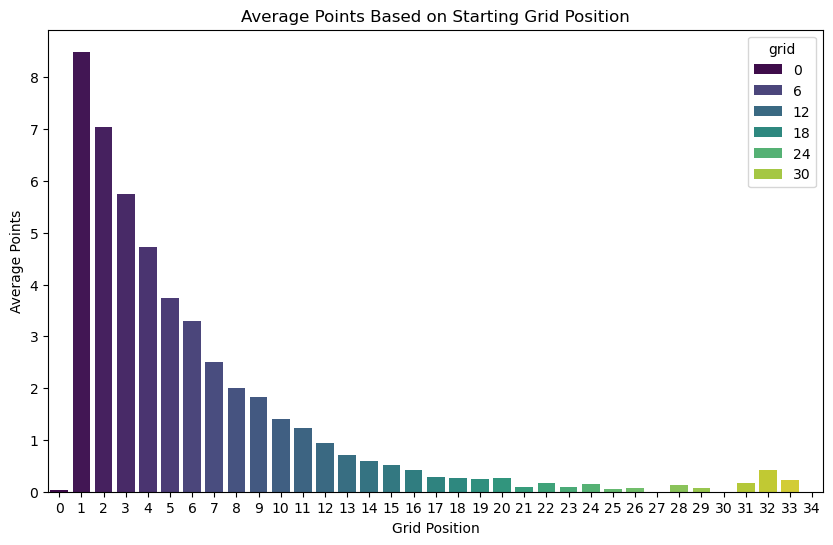

In [17]:
# Analiza broja bodova na temelju grid pozicije
grid_points = filtered_data.groupby('grid')['points'].mean()

# Vizualizacija
plt.figure(figsize=(10, 6))
sns.barplot(x=grid_points.index, y=grid_points.values, palette='viridis', hue=grid_points.index)
plt.title('Average Points Based on Starting Grid Position')
plt.xlabel('Grid Position')
plt.ylabel('Average Points')
plt.show()

### Top 10 drivers with most wins

/var/folders/fm/86xn1r1j75v02cywx5pvzs900000gn/T/ipykernel_60794/92627417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['driver_name'] = filtered_data['forename'] + ' ' + filtered_data['surname']


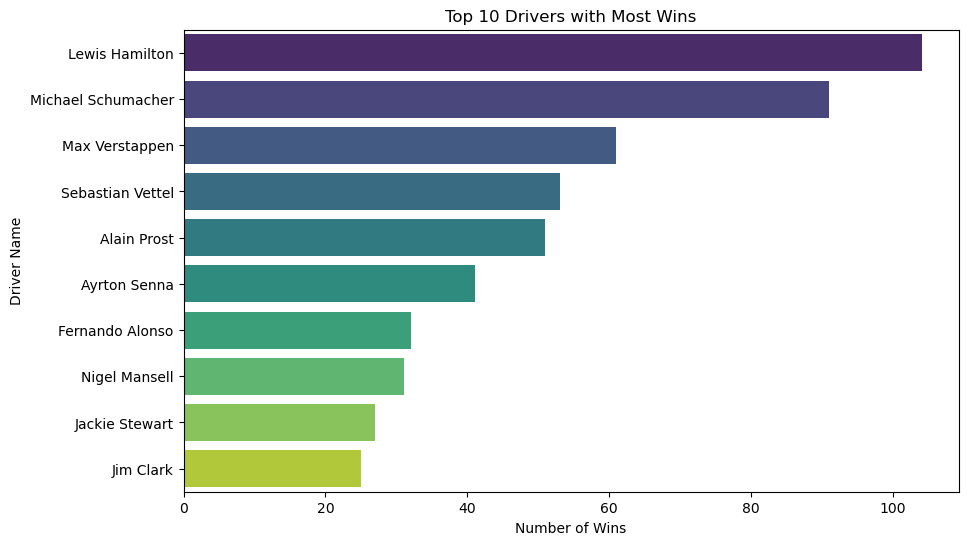

In [19]:
# Dodavanje imena vozača u merged dataset
filtered_data['driver_name'] = filtered_data['forename'] + ' ' + filtered_data['surname']

# Broj pobjeda po vozaču
wins_per_driver = filtered_data.groupby('driver_name')['positionText'].apply(lambda x: (x == '1').sum())

# Prikazivanje top 10 vozača s najviše pobjeda
top_10_wins = wins_per_driver.sort_values(ascending=False).head(10)

# Vizualizacija bez FutureWarning
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_wins.values, y=top_10_wins.index, palette='viridis', hue=None)  # Correct usage of palette
plt.title('Top 10 Drivers with Most Wins')
plt.xlabel('Number of Wins')
plt.ylabel('Driver Name')
plt.show()


### Top 10 incidents by status

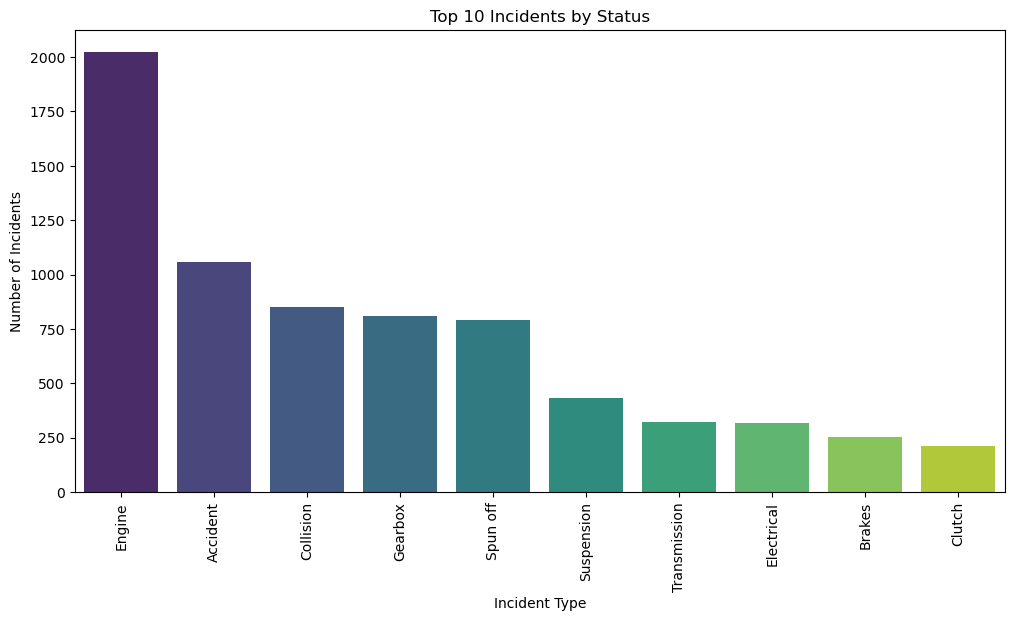

In [21]:
# Filtriranje samo incidenata
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Brojanje statusa incidenata
incident_counts = incidents['status'].value_counts()

# Filtriranje top 10 incidenata
top_10_incident_counts = incident_counts.head(10)

# Vizualizacija
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_incident_counts.index, y=top_10_incident_counts.values, palette='viridis')
plt.title('Top 10 Incidents by Status')
plt.xlabel('Incident Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.show()

### Top 10 Circuits with Most Incidents

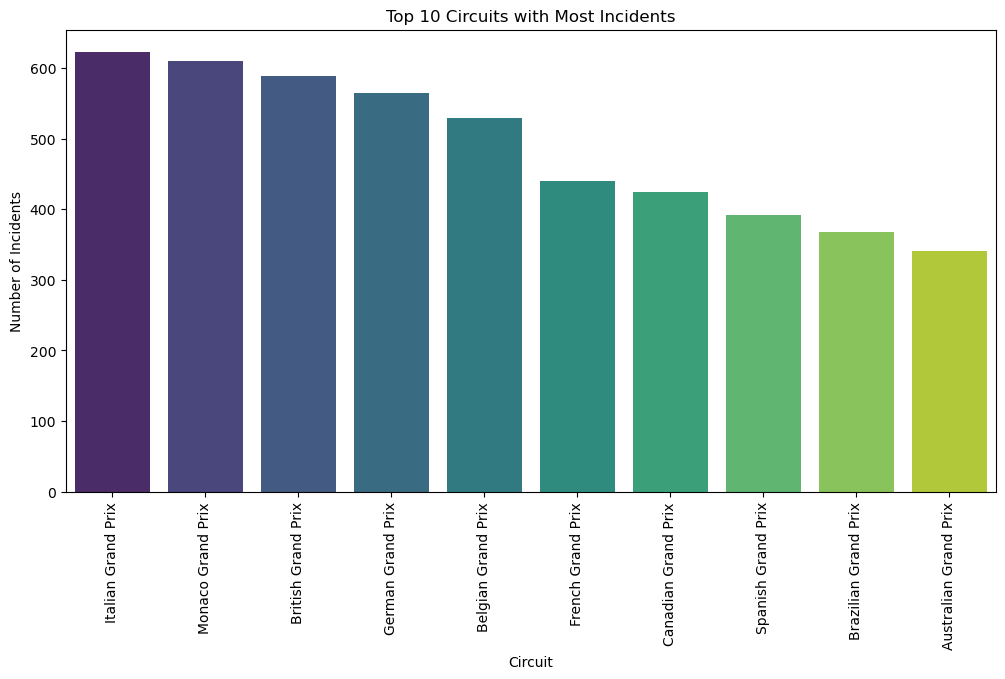

In [23]:
# Filtriranje samo incidenata
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Brojanje incidenata po stazi
incidents_per_circuit = incidents.groupby('name')['status'].count()

# Odabir top 10 staza s najviše incidenata
top_10_incidents_per_circuit = incidents_per_circuit.sort_values(ascending=False).head(10)

# Vizualizacija
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_incidents_per_circuit.index, y=top_10_incidents_per_circuit.values, palette='viridis')
plt.title('Top 10 Circuits with Most Incidents')
plt.xlabel('Circuit')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.show()


### Incident per number of laps

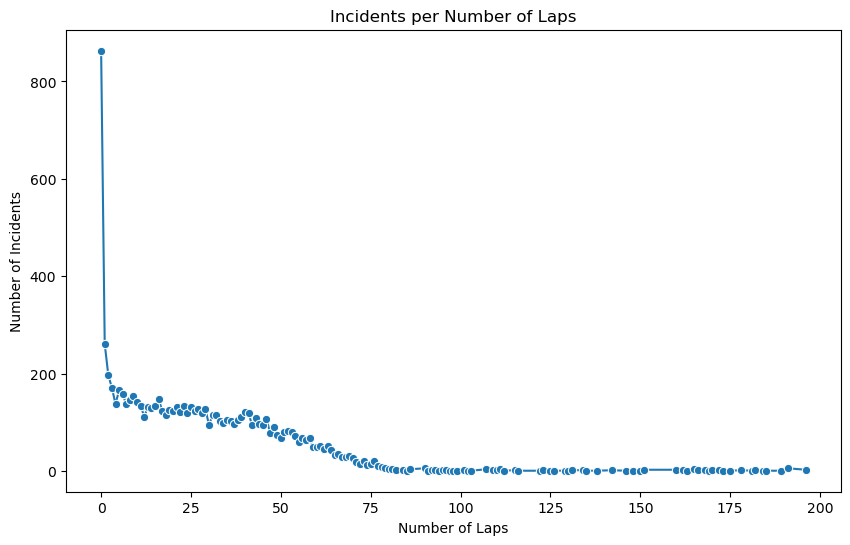

In [25]:
# Filtriranje samo incidenata
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Broj incidenata po broju krugova
incidents_per_laps = incidents.groupby('laps')['status'].count()

# Vizualizacija
plt.figure(figsize=(10, 6))
sns.lineplot(x=incidents_per_laps.index, y=incidents_per_laps.values, marker='o')
plt.title('Incidents per Number of Laps')
plt.xlabel('Number of Laps')
plt.ylabel('Number of Incidents')
plt.show()

### Incidents vs Points per driver

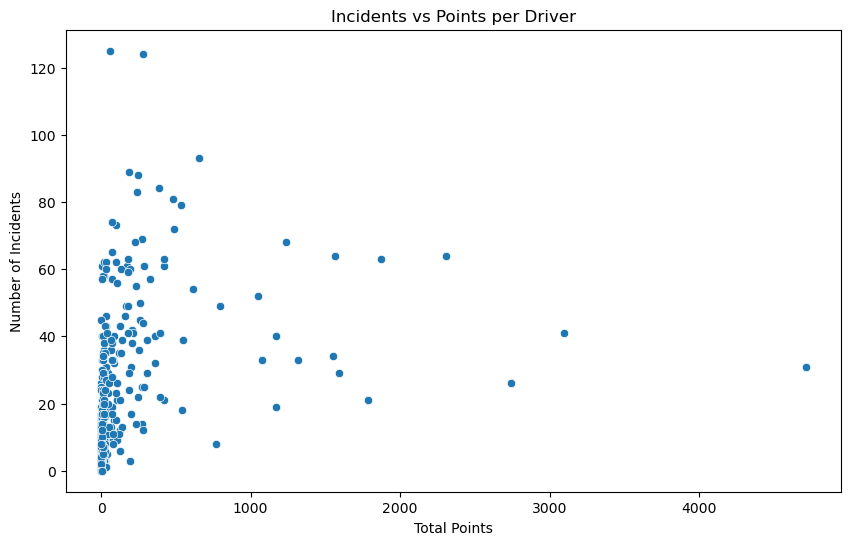

In [27]:
# Kreiranje novog DataFrame-a za vozače i njihove bodove
driver_points = filtered_data.groupby('driverId')['points'].sum()

# Brojanje incidenata po vozaču
incidents_per_driver = filtered_data[filtered_data['status'].isin(incident_statuses)].groupby('driverId').size()

# Kombiniranje bodova i broja incidenata u jedan DataFrame
driver_incidents_points = pd.DataFrame({
    'points': driver_points,
    'incidents': incidents_per_driver
}).fillna(0)  # U slučaju da neki vozači nemaju incidente, popunite s 0

# Vizualizacija korelacije između broja incidenata i osvojenih bodova
plt.figure(figsize=(10, 6))
sns.scatterplot(x=driver_incidents_points['points'], y=driver_incidents_points['incidents'])
plt.title('Incidents vs Points per Driver')
plt.xlabel('Total Points')
plt.ylabel('Number of Incidents')
plt.show()


### Incidents per year

/var/folders/fm/86xn1r1j75v02cywx5pvzs900000gn/T/ipykernel_60794/2210558692.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=incidents_per_year.index, y=incidents_per_year.values, marker='o', palette='viridis')


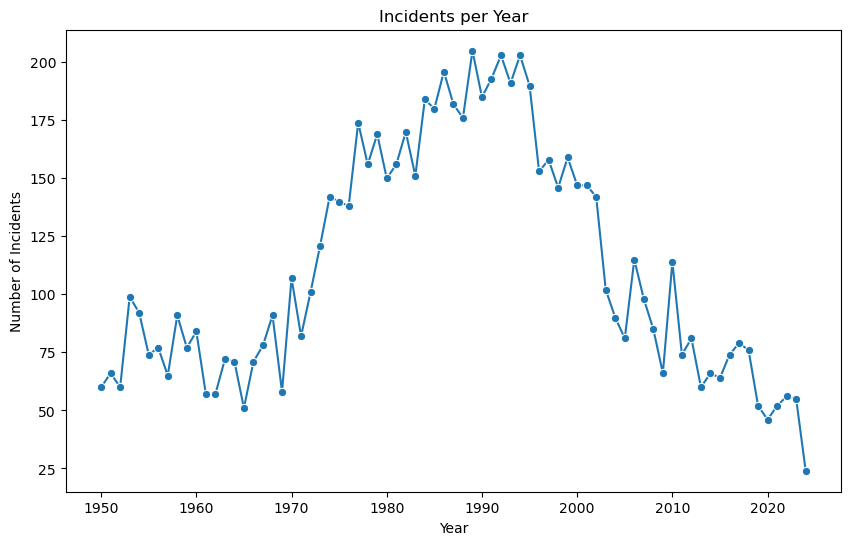

In [29]:
# Filtriranje samo incidenta
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Brojanje incidenata po godini
incidents_per_year = incidents.groupby('year')['status'].count()

# Vizualizacija
plt.figure(figsize=(10, 6))
sns.lineplot(x=incidents_per_year.index, y=incidents_per_year.values, marker='o', palette='viridis')
plt.title('Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


### wins per year and point per year plots

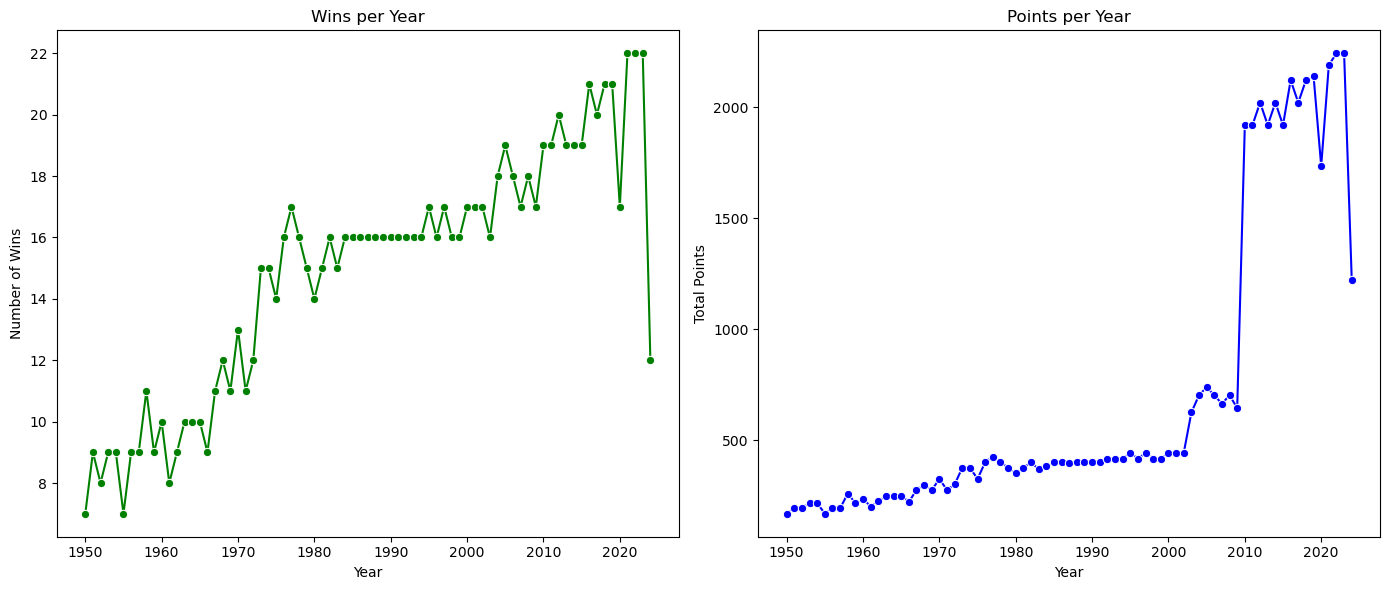

In [31]:
# Broj pobjeda po godini
wins_per_year = filtered_data[filtered_data['positionText'] == '1'].groupby('year')['positionText'].count()

# Broj bodova po godini
points_per_year = filtered_data.groupby('year')['points'].sum()

# Vizualizacija
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pobjede
sns.lineplot(x=wins_per_year.index, y=wins_per_year.values, ax=ax[0], marker='o', color='green')
ax[0].set_title('Wins per Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Wins')

# Bodovi
sns.lineplot(x=points_per_year.index, y=points_per_year.values, ax=ax[1], marker='o', color='blue')
ax[1].set_title('Points per Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Total Points')

plt.tight_layout()
plt.show()

### Position change after incidents

/var/folders/fm/86xn1r1j75v02cywx5pvzs900000gn/T/ipykernel_60794/3376240493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['positionChange'] = filtered_data['grid'] - filtered_data['positionOrder']


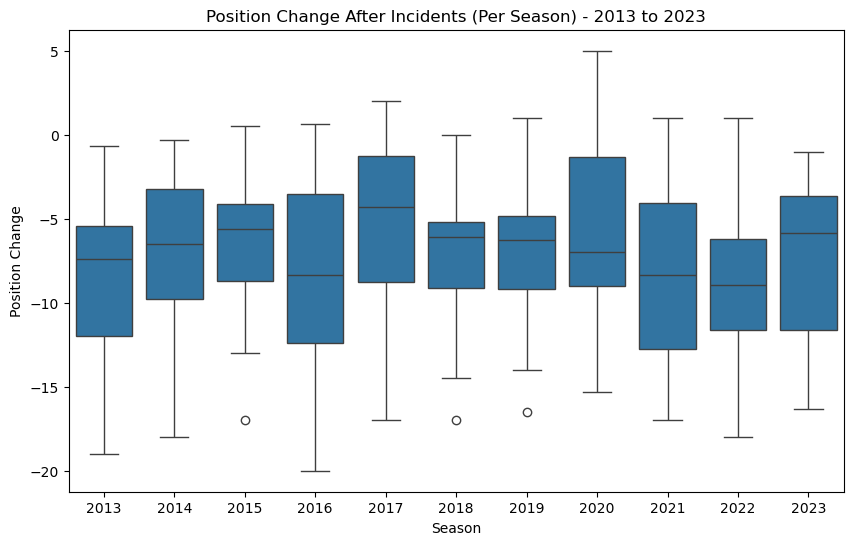

In [33]:
# Dodavanje promjene pozicije za svaku sezonu
filtered_data['positionChange'] = filtered_data['grid'] - filtered_data['positionOrder']

# Filtriranje podataka za razdoblje 2013-2023
merged_filtered = filtered_data[(filtered_data['year'] >= 2013) & (filtered_data['year'] <= 2023)]

# Analiziranje promjene pozicije za vozače koji su imali incidente
incidents_position_change_season = merged_filtered[merged_filtered['status'].isin(incident_statuses)].groupby(['year', 'driverId'])['positionChange'].mean()

# Vizualizacija promjene pozicije po sezoni
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='positionChange', data=incidents_position_change_season.reset_index())
plt.title('Position Change After Incidents (Per Season) - 2013 to 2023')
plt.xlabel('Season')
plt.ylabel('Position Change')
plt.show()

- The y-axis shows "Position Change" with negative numbers indicating a drop in position and positive numbers indicating improvement in position. Each box represents the distribution of position changes for a particular season.

- Key observations:
     - Most position changes are negative, suggesting that incidents typically result in teams/competitors losing positions rather than gaining them.
    - The median (horizontal line in each box) generally hovers between -5 and -8 positions across most seasons.
    - There's considerable variation in the spread of position changes:

    - The boxes (representing the middle 50% of the data) show varying heights
    - The whiskers (vertical lines extending from boxes) show the full range, sometimes reaching as low as -20 positions
    - A few outliers (circles) appear in some seasons (2015, 2018, 2019)


- 2017 and 2020 appear to have slightly better outcomes, with their boxes extending closer to zero and showing smaller negative impacts.
The overall pattern suggests that incidents consistently lead to position losses, though the severity of these losses varies from season to season.

### descriptive statistics and cleanup, preprocessing

1. Ciscenje podataka

In [37]:
# Provjera nedostajućih vrijednosti u datasetu
filtered_data.isnull().sum()

# Uklanjanje redova s nedostajućim vrijednostima
filtered_data = filtered_data.dropna()

# Provjera duplikata
filtered_data = filtered_data.drop_duplicates()

# Provjera tipova podataka
filtered_data.dtypes

raceId               int64
year                 int64
circuitId            int64
name                object
resultId             int64
driverId             int64
constructorId        int64
grid                 int64
positionText        object
positionOrder        int64
points             float64
laps                 int64
time_y              object
milliseconds        object
fastestLap          object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
forename            object
surname             object
status              object
driver_name         object
positionChange       int64
dtype: object

- deskriptivna statistika

In [39]:
# Deskriptivna statistika za numeričke varijable
numeric_columns = filtered_data.select_dtypes(include=['int64', 'float64']).columns
descriptive_stats_numeric = filtered_data[numeric_columns].describe()

# Prikazujemo rezultate
print(descriptive_stats_numeric)

             raceId          year     circuitId      resultId      driverId  \
count  26519.000000  26519.000000  26519.000000  26519.000000  26519.000000   
mean     546.376560   1991.099287     23.684943  13260.940986    274.357291   
std      309.642244     19.799290     18.973790   7656.813206    279.275606   
min        1.000000   1950.000000      1.000000      1.000000      1.000000   
25%      298.000000   1977.000000      9.000000   6630.500000     57.000000   
50%      527.000000   1991.000000     18.000000  13260.000000    170.000000   
75%      803.000000   2008.000000     34.000000  19889.500000    385.000000   
max     1132.000000   2024.000000     80.000000  26524.000000    860.000000   

       constructorId          grid  positionOrder        points          laps  \
count   26519.000000  26519.000000   26519.000000  26519.000000  26519.000000   
mean       49.801161     11.145820      12.814812      1.959578     46.228251   
std        61.091426      7.213453       7.67

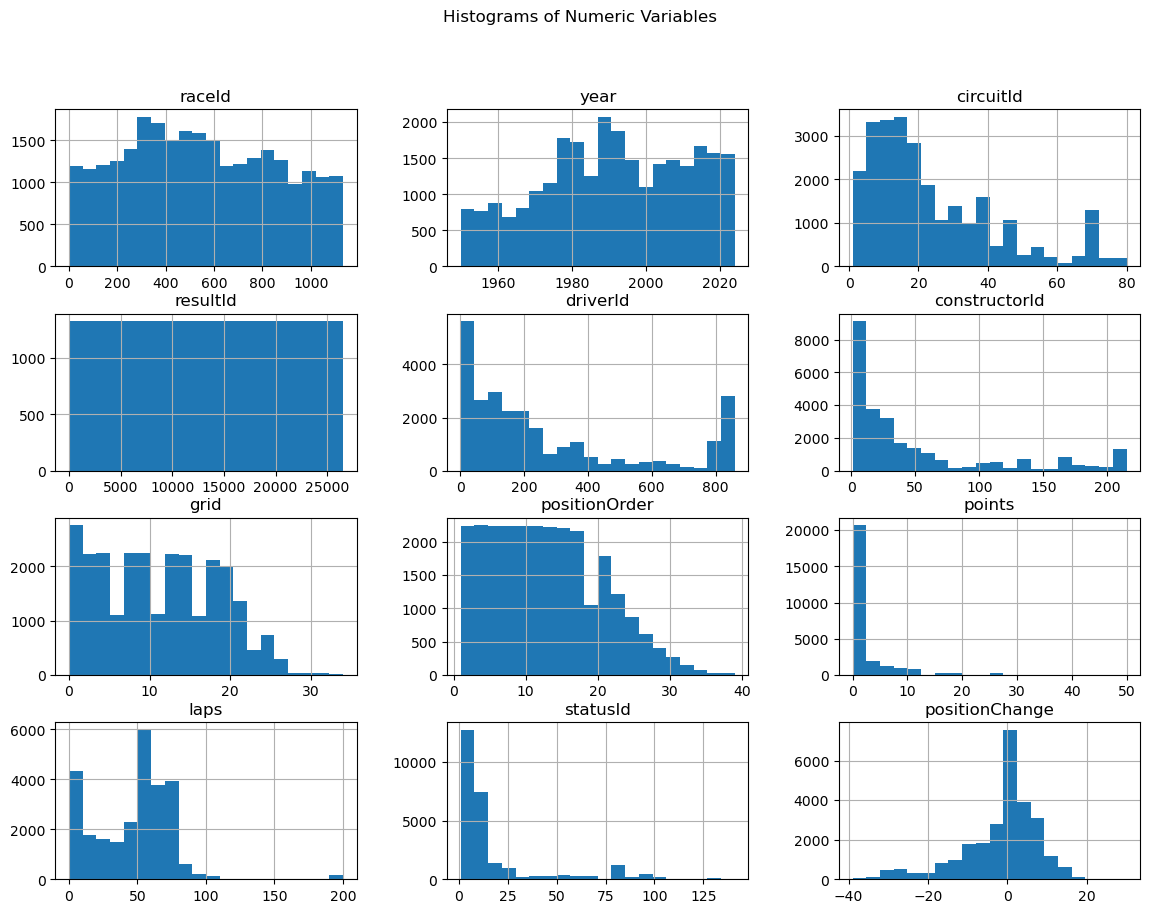

In [40]:
# Histogram za numeričke varijable
filtered_data[numeric_columns].hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numeric Variables')
plt.show()

In [41]:
# Prvo brojimo broj redova prije uklanjanja
before_removal = len(filtered_data)

# Filtriramo podatke tako da zadržimo samo one gdje grid nije 0
filtered_data = filtered_data[filtered_data['grid'] != 0]

# Brojimo broj redova nakon uklanjanja
after_removal = len(filtered_data)

# Prikazujemo broj uklonjenih redova
removed_rows = before_removal - after_removal
print(f'Number of rows removed: {removed_rows}')

# Provjeravamo prve redove da se uvjerimo da su redovi s grid = 0 uklonjeni
print(filtered_data.head())


Number of rows removed: 1631
   raceId  year  circuitId                   name  resultId  driverId  \
0       1  2009          1  Australian Grand Prix      7554        18   
1       1  2009          1  Australian Grand Prix      7555        22   
2       1  2009          1  Australian Grand Prix      7556        15   
3       1  2009          1  Australian Grand Prix      7557        10   
4       1  2009          1  Australian Grand Prix      7558         4   

   constructorId  grid positionText  positionOrder  ...  milliseconds  \
0             23     1            1              1  ...       5655784   
1             23     2            2              2  ...       5656591   
2              7    20            3              3  ...       5657388   
3              7    19            4              4  ...       5660219   
4              4    10            5              5  ...       5660663   

   fastestLap fastestLapTime fastestLapSpeed statusId  forename      surname  \
0          17

In [42]:
# Izračunajte deskriptivnu statistiku
descriptive_stats = filtered_data.describe(include=['object', 'category'])
print(descriptive_stats)


                      name positionText time_y milliseconds fastestLap  \
count                24888        24888  24888        24888      24888   
unique                  54           39   7253         7473         81   
top     British Grand Prix            R     \N           \N         \N   
freq                  1757         8864  17375        17375      16930   

       fastestLapTime fastestLapSpeed forename     surname    status  \
count           24888           24888    24888       24888     24888   
unique           7248            7459      452         739       134   
top                \N              \N   Carlos  Schumacher  Finished   
freq            16930           16930      425         531      7508   

            driver_name  
count             24888  
unique              790  
top     Fernando Alonso  
freq                391  


### adding driver skill

In [44]:
# Korak 1: Izračunaj prosječne bodove po sezoni za svakog vozača
driver_performance = filtered_data.groupby('driverId').agg(
    total_points=('points', 'sum'),
    total_seasons=('year', 'nunique')
).reset_index()

driver_performance['avg_points_per_season'] = driver_performance['total_points'] / driver_performance['total_seasons']

# Korak 2: Dodaj skill level na temelju prosječnih bodova po sezoni
high_threshold = driver_performance['avg_points_per_season'].quantile(0.9)  # Top 10%
low_threshold = driver_performance['avg_points_per_season'].quantile(0.3)  # Bottom 30%

driver_performance['driver_skill'] = driver_performance['avg_points_per_season'].apply(
    lambda x: 3 if x >= high_threshold else (1 if x <= low_threshold else 2)
)

# Korak 3: Spoji driver skill u merged dataset
filtered_data = filtered_data.merge(driver_performance[['driverId', 'driver_skill']], on='driverId', how='left')

# Provjera rezultata
print(filtered_data[['driverId', 'year', 'grid', 'positionOrder', 'status', 'driver_skill']].head())


   driverId  year  grid  positionOrder    status  driver_skill
0        18  2009     1              1  Finished             3
1        22  2009     2              2  Finished             3
2        15  2009    20              3  Finished             3
3        10  2009    19              4  Finished             2
4         4  2009    10              5  Finished             3


In [45]:
print(filtered_data)

       raceId  year  circuitId                   name  resultId  driverId  \
0           1  2009          1  Australian Grand Prix      7554        18   
1           1  2009          1  Australian Grand Prix      7555        22   
2           1  2009          1  Australian Grand Prix      7556        15   
3           1  2009          1  Australian Grand Prix      7557        10   
4           1  2009          1  Australian Grand Prix      7558         4   
...       ...   ...        ...                    ...       ...       ...   
24883    1132  2024          9     British Grand Prix     26519       822   
24884    1132  2024          9     British Grand Prix     26520       839   
24885    1132  2024          9     British Grand Prix     26522       855   
24886    1132  2024          9     British Grand Prix     26523       847   
24887    1132  2024          9     British Grand Prix     26524       842   

       constructorId  grid positionText  positionOrder  ...  fastestLap  \


### adding grid_level

In [47]:
# Izračunavamo broj incidenata na svakoj grid poziciji
incidents_by_grid = filtered_data[filtered_data['status'].isin(incident_statuses)].groupby('grid')['status'].count()

# Ukupan broj vožnji na svakoj grid poziciji
total_by_grid = filtered_data.groupby('grid')['status'].count()

# Vjerojatnost incidenta na svakoj grid poziciji
probability_of_incident = incidents_by_grid / total_by_grid

# Prikazujemo rezultate
print(probability_of_incident)

grid
1     0.207295
2     0.228212
3     0.240608
4     0.268750
5     0.291071
6     0.305481
7     0.297418
8     0.312444
9     0.304464
10    0.342576
11    0.349107
12    0.345291
13    0.359389
14    0.359206
15    0.365123
16    0.361213
17    0.362454
18    0.370549
19    0.370588
20    0.389061
21    0.433286
22    0.431402
23    0.410596
24    0.445221
25    0.448505
26    0.467742
27    0.456522
28    0.466667
29    0.440000
30    0.578947
31    0.388889
32    0.352941
33    0.153846
34    1.000000
Name: status, dtype: float64


In [48]:
# Definiramo pragove za kategorizaciju vjerojatnosti incidenta
high_threshold = probability_of_incident.quantile(0.9)  # Top 10% vjerojatnosti
low_threshold = probability_of_incident.quantile(0.3)  # Bottom 30% vjerojatnosti

# Dodajemo kategoriju rizika za svaku grid poziciju
def categorize_grid_risk(probability):
    if probability >= high_threshold:
        return 3
    elif probability <= low_threshold:
        return 2
    else:
        return 1

# Primjenjujemo funkciju na izračunate vjerojatnosti
grid_risk_categories = probability_of_incident.apply(categorize_grid_risk)

# Prikazujemo kategorizirane grid pozicije
print(grid_risk_categories)


grid
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    3
27    1
28    3
29    1
30    3
31    1
32    1
33    2
34    3
Name: status, dtype: int64


In [49]:
# Dodajemo grid risk level u filtered_data prema grid poziciji
filtered_data['grid_risk'] = filtered_data['grid'].map(grid_risk_categories)

# Provjeravamo rezultate
print(filtered_data[['raceId', 'driverId', 'grid', 'grid_risk']].head())

   raceId  driverId  grid  grid_risk
0       1        18     1          2
1       1        22     2          2
2       1        15    20          1
3       1        10    19          1
4       1         4    10          1


In [50]:
# Dodavanje varijable 'incident_occurred' na temelju statusa
filtered_data['incident_occurred'] = filtered_data['status'].apply(
    lambda x: 1 if x in incident_statuses else 0
)

# Provjera rezultata
print(filtered_data[['status', 'incident_occurred']].head())


     status  incident_occurred
0  Finished                  0
1  Finished                  0
2  Finished                  0
3  Finished                  0
4  Finished                  0


In [51]:
print(filtered_data.columns)

Index(['raceId', 'year', 'circuitId', 'name', 'resultId', 'driverId',
       'constructorId', 'grid', 'positionText', 'positionOrder', 'points',
       'laps', 'time_y', 'milliseconds', 'fastestLap', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status',
       'driver_name', 'positionChange', 'driver_skill', 'grid_risk',
       'incident_occurred'],
      dtype='object')


In [52]:
import pandas as pd

# Odvajanje nezavisnih (X) i zavisnih (y) varijabli
X = filtered_data.drop(['incident_occurred'], axis=1)  # Ne odabrati 'incident_occurred'
y = filtered_data['incident_occurred']  # Ovisna varijabla

# Provjera da su varijable ispravno odvojene
print(X.head())
print(y.head())

   raceId  year  circuitId                   name  resultId  driverId  \
0       1  2009          1  Australian Grand Prix      7554        18   
1       1  2009          1  Australian Grand Prix      7555        22   
2       1  2009          1  Australian Grand Prix      7556        15   
3       1  2009          1  Australian Grand Prix      7557        10   
4       1  2009          1  Australian Grand Prix      7558         4   

   constructorId  grid positionText  positionOrder  ...  fastestLapTime  \
0             23     1            1              1  ...        1:28.020   
1             23     2            2              2  ...        1:29.066   
2              7    20            3              3  ...        1:28.916   
3              7    19            4              4  ...        1:28.416   
4              4    10            5              5  ...        1:28.712   

   fastestLapSpeed statusId  forename      surname    status  \
0          216.891        1    Jenson       Bu

In [53]:
print(filtered_data.columns)

Index(['raceId', 'year', 'circuitId', 'name', 'resultId', 'driverId',
       'constructorId', 'grid', 'positionText', 'positionOrder', 'points',
       'laps', 'time_y', 'milliseconds', 'fastestLap', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status',
       'driver_name', 'positionChange', 'driver_skill', 'grid_risk',
       'incident_occurred'],
      dtype='object')


In [54]:
from sklearn.utils import resample

# Podijelimo dataset na dvije klase
df_no = filtered_data[filtered_data['incident_occurred'] == 0]
df_yes = filtered_data[filtered_data['incident_occurred'] == 1]

# Resample (under-sampling) No slučajeva da ih bude isto koliko i Yes slučajeva
df_no_undersampled = resample(df_no, 
                              replace=False,    # Bez vraćanja, samo uzimamo uzorke
                              n_samples=len(df_yes), # Koliko imamo Yes slučajeva
                              random_state=42)    # Za reproducibilnost

# Spajanje oba skupa podataka
df_balanced = pd.concat([df_yes, df_no_undersampled])
print(df_balanced)


       raceId  year  circuitId                   name  resultId  driverId  \
12          1  2009          1  Australian Grand Prix      7566        20   
13          1  2009          1  Australian Grand Prix      7567         9   
14          1  2009          1  Australian Grand Prix      7568         8   
15          1  2009          1  Australian Grand Prix      7569        13   
16          1  2009          1  Australian Grand Prix      7570        12   
...       ...   ...        ...                    ...       ...       ...   
1389       67  2006         14     Italian Grand Prix      1051        30   
20981     931  2015          6      Monaco Grand Prix     22636         3   
7968      355  2010         24   Abu Dhabi Grand Prix     20763       153   
22218     989  2018          1  Australian Grand Prix     23788       807   
1955       95  2004          6      Monaco Grand Prix      1617        22   

       constructorId  grid positionText  positionOrder  ...  fastestLapSpee

grid_risk nije normalno distribuiran (p-value = 0.0)
driver_skill nije normalno distribuiran (p-value = 0.0)
incident_occurred nije normalno distribuiran (p-value = 0.0)

Rezultati korelacije između varijabli:
grid_risk: Spearman korelacija = -0.09349744340861424, p-vrijednost = 1.3028676784638251e-33
driver_skill: Spearman korelacija = -0.16935969896319647, p-vrijednost = 3.0351475346947563e-107
incident_occurred: Spearman korelacija = 1.0, p-vrijednost = 0.0


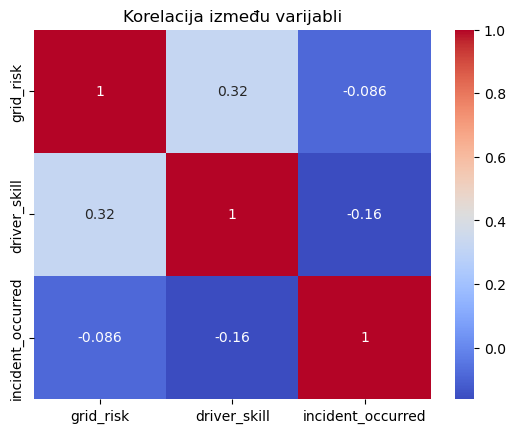

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest, pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Funkcija za provjeru normalnosti i izračun korelacije
def check_normality_and_corr(df):
    # Testiranje normalnosti za 'grid_risk', 'driver_skill', i 'incident_occurred'
    variables = ['grid_risk', 'driver_skill', 'incident_occurred']
    results = {}

    for var in variables:
        # Kolmogorov-Smirnov test za normalnost
        stat, p_value = normaltest(df[var].dropna())
        if p_value > 0.05:
            print(f"{var} je normalno distribuiran (p-value = {p_value})")
            # Pearsonova korelacija
            corr, p_val = pearsonr(df[var], df['incident_occurred'])
            results[var] = {'test': 'Pearson', 'correlation': corr, 'p-vrijednost': p_val}
        else:
            print(f"{var} nije normalno distribuiran (p-value = {p_value})")
            # Spearmanova korelacija
            corr, p_val = spearmanr(df[var], df['incident_occurred'])
            results[var] = {'test': 'Spearman', 'correlation': corr, 'p-vrijednost': p_val}
    
    return results

# Primjena funkcije na vašu grupu podataka
results = check_normality_and_corr(df_balanced)

# Ispis rezultata korelacije
print("\nRezultati korelacije između varijabli:")
for var, result in results.items():
    print(f"{var}: {result['test']} korelacija = {result['correlation']}, p-vrijednost = {result['p-vrijednost']}")

# Vizualizacija korelacija
corr_matrix = df_balanced[['grid_risk', 'driver_skill', 'incident_occurred']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korelacija između varijabli")
plt.show()


In [56]:
import statsmodels.api as sm

# Ovisna varijabla: incident_occurred (0 ili 1)
# Neovisne varijable: numeričke varijable poput 'grid_position', 'driver_skill'
X = df_balanced[['grid_risk', 'driver_skill']]  # Neovisne varijable
y = df_balanced['incident_occurred']  # Ovisna varijabla

# Dodajte konstantnu vrijednost (intercept)
X = sm.add_constant(X)

# Izgradnja Logit modela
model = sm.Logit(y, X)
result = model.fit()

# Prikaz rezultata
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.679258
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      incident_occurred   No. Observations:                16630
Model:                          Logit   Df Residuals:                    16627
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                 0.02004
Time:                        15:27:09   Log-Likelihood:                -11296.
converged:                       True   LL-Null:                       -11527.
Covariance Type:            nonrobust   LLR p-value:                4.902e-101
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3208      0.066     20.107      0.000       1.192       1.450
grid_risk       -0.1473

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Podjela na treniranje i testiranje
X = df_balanced[['grid_risk', 'driver_skill']]
y = df_balanced['incident_occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Izrada modela
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluacija modela
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2452
           1       0.59      0.61      0.60      2537

    accuracy                           0.58      4989
   macro avg       0.58      0.58      0.58      4989
weighted avg       0.58      0.58      0.58      4989



In [131]:
print(df_simulated)

       raceId  year  circuitId                   name  resultId  driverId  \
12          1  2009          1  Australian Grand Prix      7566        20   
13          1  2009          1  Australian Grand Prix      7567         9   
14          1  2009          1  Australian Grand Prix      7568         8   
15          1  2009          1  Australian Grand Prix      7569        13   
34          2  2009          2   Malaysian Grand Prix      7588        20   
...       ...   ...        ...                    ...       ...       ...   
2943      143  2001         18   Brazilian Grand Prix      2609        58   
14440     615  1973         20      German Grand Prix     15209       329   
17558     769  1958         13     Belgian Grand Prix     18592       455   
8619      380  1988         10      German Grand Prix      8752       146   
2087      101  2004         10      German Grand Prix      1749        45   

       constructorId  grid positionText  positionOrder  ...  fastestLapSpee

Accuracy: 0.59
Confusion Matrix:
[[1368 1114]
 [ 938 1569]]


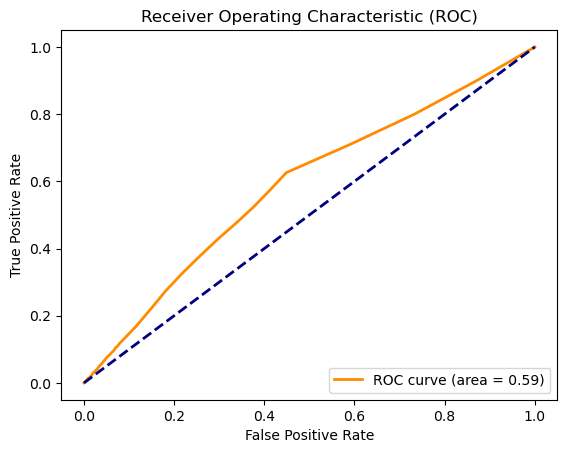

AUC: 0.59


In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Predviđanje na testnim podacima
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # prednosti za klasu "1" (incident)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.2f}")


In [63]:
print(df_balanced)

       raceId  year  circuitId                   name  resultId  driverId  \
12          1  2009          1  Australian Grand Prix      7566        20   
13          1  2009          1  Australian Grand Prix      7567         9   
14          1  2009          1  Australian Grand Prix      7568         8   
15          1  2009          1  Australian Grand Prix      7569        13   
16          1  2009          1  Australian Grand Prix      7570        12   
...       ...   ...        ...                    ...       ...       ...   
1389       67  2006         14     Italian Grand Prix      1051        30   
20981     931  2015          6      Monaco Grand Prix     22636         3   
7968      355  2010         24   Abu Dhabi Grand Prix     20763       153   
22218     989  2018          1  Australian Grand Prix     23788       807   
1955       95  2004          6      Monaco Grand Prix      1617        22   

       constructorId  grid positionText  positionOrder  ...  fastestLapSpee

In [64]:
print(df_simulated)

       raceId  year  circuitId                   name  resultId  driverId  \
12          1  2009          1  Australian Grand Prix      7566        20   
13          1  2009          1  Australian Grand Prix      7567         9   
14          1  2009          1  Australian Grand Prix      7568         8   
15          1  2009          1  Australian Grand Prix      7569        13   
34          2  2009          2   Malaysian Grand Prix      7588        20   
...       ...   ...        ...                    ...       ...       ...   
2943      143  2001         18   Brazilian Grand Prix      2609        58   
14440     615  1973         20      German Grand Prix     15209       329   
17558     769  1958         13     Belgian Grand Prix     18592       455   
8619      380  1988         10      German Grand Prix      8752       146   
2087      101  2004         10      German Grand Prix      1749        45   

       constructorId  grid positionText  positionOrder  ...  fastestLapSpee

Accuracy: 0.59
Confusion Matrix:
[[1349 1103]
 [ 960 1577]]


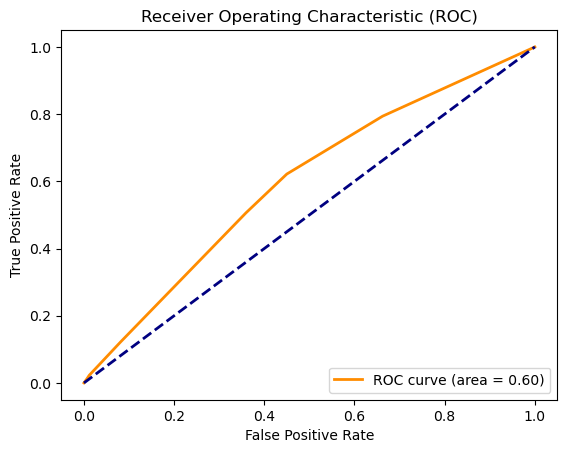

AUC: 0.60
Feature Importance:
grid_risk: 0.2068
driver_skill: 0.7932


'\n# Uklanjanje manje važnih varijabli na temelju Feature Importance\n# Ako želite optimizirati model, možete ukloniti varijable koje imaju malu važnost:\n# Na primjer, možemo postaviti prag za značajnost varijabli.\nthreshold = 0.05  # Svi varijable s manjim značajem bit će uklonjene\nimportant_features = X.columns[rf_model.feature_importances_ > threshold]\n\n# Ponovno treniranje modela s važnim varijablama\nX_train_important = X_train[important_features]\nX_test_important = X_test[important_features]\n\nrf_model_optimized = RandomForestClassifier(random_state=42)\nrf_model_optimized.fit(X_train_important, y_train)\n\n# Predviđanje i evaluacija optimiziranog modela\ny_pred_optimized = rf_model_optimized.predict(X_test_important)\ny_pred_prob_optimized = rf_model_optimized.predict_proba(X_test_important)[:, 1]\n\naccuracy_optimized = accuracy_score(y_test, y_pred_optimized)\nprint(f"Optimized Accuracy: {accuracy_optimized:.2f}")\n\n# Confusion Matrix za optimizirani model\ncm_optimize

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Podjela na trening i test skup
X = df_balanced[['grid_risk', 'driver_skill']]  # Ovo su nezavisne varijable
y = df_balanced['incident_occurred']  # Ovisna varijabla (incident_occurred)

# Podjela na treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Izrada Random Forest modela
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predviđanje na testnim podacima
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluacija modela
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.2f}")

# Ispisivanje važnosti varijabli
print("Feature Importance:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")
"""
# Uklanjanje manje važnih varijabli na temelju Feature Importance
# Ako želite optimizirati model, možete ukloniti varijable koje imaju malu važnost:
# Na primjer, možemo postaviti prag za značajnost varijabli.
threshold = 0.05  # Svi varijable s manjim značajem bit će uklonjene
important_features = X.columns[rf_model.feature_importances_ > threshold]

# Ponovno treniranje modela s važnim varijablama
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

rf_model_optimized = RandomForestClassifier(random_state=42)
rf_model_optimized.fit(X_train_important, y_train)

# Predviđanje i evaluacija optimiziranog modela
y_pred_optimized = rf_model_optimized.predict(X_test_important)
y_pred_prob_optimized = rf_model_optimized.predict_proba(X_test_important)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {accuracy_optimized:.2f}")

# Confusion Matrix za optimizirani model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("Optimized Confusion Matrix:")
print(cm_optimized)

# ROC Curve za optimizirani model
fpr_optimized, tpr_optimized, thresholds_optimized = roc_curve(y_test, y_pred_prob_optimized)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='Optimized ROC curve (area = %0.2f)' % auc(fpr_optimized, tpr_optimized))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC za optimizirani model
auc_score_optimized = roc_auc_score(y_test, y_pred_prob_optimized)
print(f"Optimized AUC: {auc_score_optimized:.2f}")
"""

In [181]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the risk positions based on the earlier example
risk_positions = {
    3: [26, 28, 30, 34],  # High risk
    2: [3, 4, 7, 6, 9, 2, 1, 8, 5, 33],  # Medium risk
    1: [14, 11, 12, 13, 20, 18, 16, 15, 17, 19, 10, 22, 21, 23, 24, 25, 29, 27, 31, 32]  # Low risk
}

# Function to calculate incident probability with handling for dynamic base probability
def calculate_incident_probability(row, base_probability=0.2):
    """
    Calculate the probability of an incident based on grid risk and driver skill.
    Args:
        row (pd.Series): Row of the dataframe containing grid_risk and driver_skill.
        base_probability (float): Base probability of an incident.
        
    Returns:
        float: Total probability of an incident.
    """
    # Increase the chance based on grid_risk
    risk_multiplier = 0.1 * row['grid_risk']  # Higher grid_risk increases the chance

    # Decrease the chance based on skill level (lower skill means higher probability of incident)
    skill_multiplier = 0.05 * (3 - row['driver_skill'])  # Lower skill increases the chance

    # Calculate total incident probability
    total_probability = base_probability + risk_multiplier + skill_multiplier

    # Ensure probability is within the range [0, 1]
    total_probability = min(max(total_probability, 0), 1)

    return total_probability

# Function to simulate the movement of drivers
def simulate_position_change(df, risk_positions):
    # Split drivers by their skill levels
    high_skill = df[df['driver_skill'] == 3].copy()
    medium_skill = df[df['driver_skill'] == 2].copy()
    low_skill = df[df['driver_skill'] == 1].copy()

    # Create new grid_risk positions by repeating each skill level's risk positions
    high_positions = np.tile(risk_positions[3], len(high_skill) // len(risk_positions[3]) + 1)[:len(high_skill)]
    medium_positions = np.tile(risk_positions[2], len(medium_skill) // len(risk_positions[2]) + 1)[:len(medium_skill)]
    low_positions = np.tile(risk_positions[1], len(low_skill) // len(risk_positions[1]) + 1)[:len(low_skill)]

    # Assign new grid_risk positions to drivers
    high_skill['grid_risk'] = 3
    medium_skill['grid_risk'] = 2
    low_skill['grid_risk'] = 1

    # Combine all drivers into a new DataFrame
    new_df = pd.concat([high_skill, medium_skill, low_skill])

    # Add random incident probability based on skill and position risk
    def random_incident(row):
        # Calculate the total incident probability
        total_probability = calculate_incident_probability(row)

        # Randomly choose 0 or 1 based on the total probability
        return np.random.choice([0, 1], p=[1 - total_probability, total_probability])

    # Apply the function to the DataFrame
    new_df['incident_occurred'] = new_df.apply(random_incident, axis=1)

    return new_df

# Simulate the movement of drivers and add incident information
df_simulated = simulate_position_change(df_balanced, risk_positions)

# Check the 'grid_risk' and 'incident_occurred' columns to see how they look
print(df_simulated[['driverId', 'grid_risk', 'driver_skill', 'incident_occurred']].head())

# Split the data into training and testing sets
X = df_simulated[['grid_risk', 'driver_skill']]  # Features: grid_risk and driver_skill
y = df_simulated['incident_occurred']  # Target variable: incident_occurred
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set

# Evaluate the model performance
print(classification_report(y_test, y_pred))  # Print classification report for evaluation


    driverId  grid_risk  driver_skill  incident_occurred
12        20          3             3                  1
13         9          3             3                  0
14         8          3             3                  1
15        13          3             3                  0
34        20          3             3                  1
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2649
           1       0.50      0.49      0.50      2340

    accuracy                           0.53      4989
   macro avg       0.53      0.53      0.53      4989
weighted avg       0.53      0.53      0.53      4989



In [185]:
# Izračun prosječnog incidenta prije simulacije
original_incident_rate = df_balanced.groupby(['grid_risk', 'driver_skill'])['incident_occurred'].mean().reset_index()
original_incident_rate.rename(columns={'incident_occurred': 'avg_incident_rate_before'}, inplace=True)

# Izračun prosječnog incidenta nakon simulacije
simulated_incident_rate = df_simulated.groupby(['grid_risk', 'driver_skill'])['incident_occurred'].mean().reset_index()
simulated_incident_rate.rename(columns={'incident_occurred': 'avg_incident_rate_after'}, inplace=True)

# Spojite originalne i simulirane rezultate
incident_rate_comparison = pd.merge(original_incident_rate, simulated_incident_rate, on=['grid_risk', 'driver_skill'])

# Prikaz rezultata
print(incident_rate_comparison)


   grid_risk  driver_skill  avg_incident_rate_before  avg_incident_rate_after
0          1             1                   0.59388                 0.404255
1          2             2                   0.56204                 0.439100
2          3             3                   0.37500                 0.504248


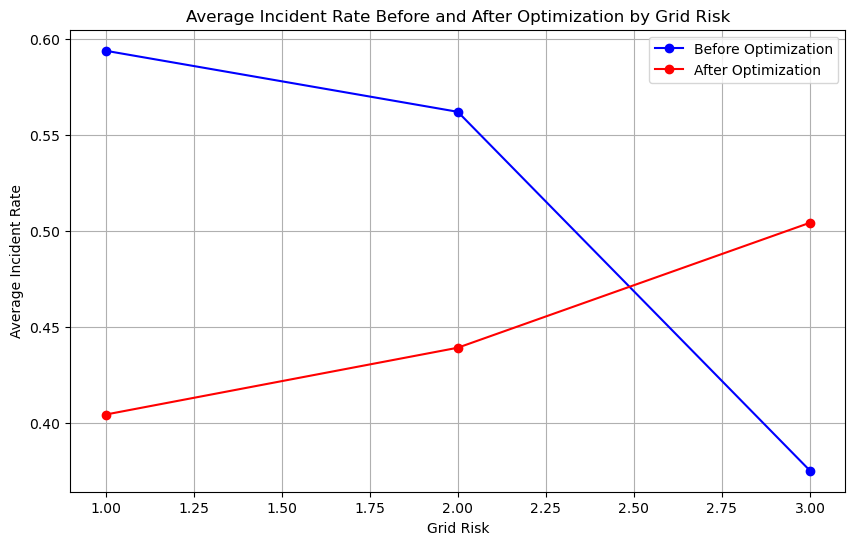

In [187]:
import matplotlib.pyplot as plt

# Prvo ćemo prikazati rezultate u formi grafa
data = {
    "grid_risk": [1, 2, 3],
    "driver_skill": [1, 2, 3],
    "avg_incident_rate_before": [0.59388, 0.56204, 0.37500],
    "avg_incident_rate_after": [0.404255, 0.439100, 0.504248]
}

df_results = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(df_results['grid_risk'], df_results['avg_incident_rate_before'], label='Before Optimization', marker='o', color='blue')
plt.plot(df_results['grid_risk'], df_results['avg_incident_rate_after'], label='After Optimization', marker='o', color='red')

# Adding labels and title
plt.xlabel('Grid Risk')
plt.ylabel('Average Incident Rate')
plt.title('Average Incident Rate Before and After Optimization by Grid Risk')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()